<p style="color:blue;font-size:60px" > <b>Molecular Database Screening</b> </p>

# General Imports

In [1]:
# -- Data & Plotting
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path

# Progress Bar
from tqdm import tqdm, tnrange, tqdm_notebook
tqdm.pandas()

# -- RDKit
import rdkit
from rdkit import Chem
from rdkit.Chem import AllChem, Draw, PandasTools
from rdkit.Chem.Draw import IPythonConsole
PandasTools.RenderImagesInAllDataFrames()
print("RDKit Version: ", rdkit.__version__)

RDKit Version:  2023.09.6


In [2]:
import warnings
warnings.filterwarnings("ignore")

# Virtual Screening
Today, we will see an example of screening a molecular database in search for new potential drug hits.

In the first stages of Drug discovery, we are interested in finding a molecule that binds to a target with high affinity (the "hit" molecule), which later can be optimized to fine tune many of it's properties. But how to find this first 'needle in the haystack'?

Computational approaches can easily design huge number of molecules (billions/trillions/more?) by enumerating virtual libraries. However, 
- It is likely that only a fraction of such compounds can be synthesized in practice. 
- The cost for synthesis and storage of such collections is prohibitive.

On the other hand, there are pre-existing databases of compounds available:
- Pharmaceutical companies already have collections of compounds, synthesized in previous campaigns.
- Chemical vendors offer compound collections for immediate purchase.
- Some vendors even offer 'make-on-demand' services based on a limited number of reactions and building blocks.

The size of the collections available can easily reach billions of compounds!

<div class="alert alert-info" role="alert">
    Virtual database screening methods offer a way to prioritize the compounds for testing, greatly reducing the costs in this phase.
</div> 

## Methods of Virtual Screening

The methods used for virtual screening can be roughly divided into two families:

### **Ligand-based**
- Requires knowledge of *ligands*
- Examples:
    - Similarity Search
    - Pharmacophore Search

![MyGif](media/pharmacophore.gif "segment")

### **Structure-based**
- Requires knowledge of *target*
- Examples:
    - Docking
    - Molecular Dynamics
    
![MyGif](media/docking.gif "segment")

Details on those have been covered in previous classes. Let's look at an example.

# Docking Example

In [6]:
from vina import Vina
print("Vina Version: ", Vina().cite() )

There's a small sample (10 molecules) in the `data/ligands` folder. Here we can use [AutoDock Vina](https://autodock-vina.readthedocs.io/en/latest/index.html) to dock them to a target, and here we are looking for molecules that can bind the WWE domain of human RNF146 ([PDB:3V3L](https://www.rcsb.org/structure/3v3l)).

First, lets set some docking parameters:

In [7]:
# Control variables
EXHAUSTIVENESS     = 8
N_POSES            = 5
VINA_CPUS          = 4
ENERGY_RANGE       = 5.0

# -- Grid Definition
center_x = 23.266
center_y = 56.891
center_z = 86.524
center = (center_x, center_y, center_z)

size_x = 18.0
size_y = 18.0
size_z = 18.0
size = (size_x, size_y, size_z)

The files for docking have already been prepared:

In [8]:
target_file = "data/3V3L_A_prepared.pdbqt"
lig_library = Path("data/ligands")
ligands = list(str(x) for x in lig_library.glob("**/*.pdbqt"))

In [9]:
ligands

['data/ligands/Z1001209862-4.pdbqt',
 'data/ligands/Z1001209862-1.pdbqt',
 'data/ligands/Z1001209862-3.pdbqt',
 'data/ligands/Z1001209862-6.pdbqt',
 'data/ligands/Z1001056548-1.pdbqt',
 'data/ligands/Z1000264452-1.pdbqt',
 'data/ligands/Z1001209862-5.pdbqt',
 'data/ligands/Z1001262418-1.pdbqt',
 'data/ligands/Z1001209862-2.pdbqt',
 'data/ligands/Z1001771158-1.pdbqt']

To use Vina, we create a `docker` object:

In [10]:
docker = Vina(sf_name='Vina', cpu=VINA_CPUS, verbosity=0)
docker.set_receptor(target_file)

Now we can dock the compounds. You can play with the code below to dock more compounds:

In [11]:
%%time
docking_scores = []
N_TO_DOCK = 1 # Max 10, which is what we have.
for ligand in ligands[:N_TO_DOCK]:
    print("Docking ligand: ", ligand, flush=True)
    docker.set_ligand_from_file(ligand)
    docker.compute_vina_maps(center, size)
    docker.dock(exhaustiveness=EXHAUSTIVENESS, n_poses=N_POSES)
    print("Docking Scores:\n  [ total  inter  intra  torns -ibest]", )
    for pose, energy in enumerate(docker.energies(n_poses=N_POSES)):
        print(pose, energy)
    docking_scores.append(docker.energies(n_poses=1)[0][0])
    print("*"*80)

Docking ligand:  data/ligands/Z1001209862-4.pdbqt
Docking Scores:
  [ total  inter  intra  torns -ibest]
0 [-6.525 -8.051 -0.532  1.526 -0.532]
1 [-6.083 -7.707 -0.33   1.422 -0.532]
2 [-6.018 -7.341 -0.616  1.407 -0.532]
3 [-5.994 -7.314 -0.613  1.402 -0.532]
4 [-5.376 -6.609 -0.556  1.257 -0.532]
********************************************************************************
CPU times: user 33.4 s, sys: 125 ms, total: 33.5 s
Wall time: 10.3 s


All energies are in kcal/mol. The final binding energy (Vina Score) is calculated as the sum of the energy components:
$$
E_t = E_{inter} + E_{intra} + E_{tors} - E_{intra-best}
$$

Look at all the docking energies obtained (depends on how many molecules you docked):

In [12]:
docking_scores

[-6.525]

<div class="alert alert-info" role="alert">
    <b>About timings</b> <br>
    Here, with 4 processors dedicated to the docking, you are probably getting something ~10s/molecule. With parallel process, it is possible to reduce this number to ~4s/molecule or even more if using GPU-based implementations.
</div> 

# Some Molecular Databases

In [13]:
libs = pd.read_csv('data/Libraries.csv')#.sort_values(by='# cpds')
libs

,Name,Description,# cpds,days @10s/cpd,years
0,Tocris_Max,A library of 1280 biologically active compound...,1.280000e+03,0.15,0.00
1,Lopac1280,biologically annotated collection of inhibitor...,1.280000e+03,0.15,0.00
2,Prestwick Chemical Library,"A unique collection of 1520 small molecules, 9...",1.520000e+03,0.18,0.00
3,ZINClick Diversity,ZINClick is a virtual combinatorial database o...,2.500000e+03,0.29,0.00
4,Otava PrimScreen10,OTAVA’s Diversity Library comprises the most m...,1.000000e+04,1.16,0.00
5,DrugBank 5-1-8,"Database of Approved, experimental, nutraceuti...",1.117400e+04,1.29,0.00
6,TimTec ActiProbe 25k,Assembled from ActiGlobe set (unavailable for ...,2.500000e+04,2.89,0.01
7,ChemSpace Lead Like 25k,Selected diversity set from the in-stock lead-...,2.500000e+04,2.89,0.01
8,TimTec ActiGlobe,Full TimTec Actiglobe collection,5.000000e+04,5.79,0.02
9,ChemBridge DiverSet-CL,Compounds were selected from ChemBridge’s CORE...,9.752000e+04,11.28,0.03


# Accelerating Screening with ML

We will try to accelerate the process using machine-learning. For this purpose, we have a database of ~200k compounds that we want to screen against the same target. The general process is like:

![process](media/screening_process.png)

<div class="alert alert-info" role="alert">
    <b>To Speed Up the Class</b> <br>
    Instead of actually docking the compounds, we already provide the docking energies here, so we can skip the orange boxes. In a real project, you would need to dock the selected compounds.
</div> 

In [14]:
database = pd.read_pickle('/blue/pha6935/share/data/database.pkl.bz2')
database.sample(5)

,MoleculeID,Scores,SMILES,RDKit
211472,Z1956747141,-5.778,CC(C)c1nn(C)cc1NS(=O)(=O)c1cn(C)cn1,"[1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, ..."
183907,Z1725736029,-6.269,CC(C)C1(C)CC1C(=O)N1CCN(C(=O)CN2CCOCC2)CC1,"[0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, ..."
24173,Z367741100,-7.884,COc1ccc(Cl)cc1C(=O)N1CCCC1C(=O)Nc1cc(C)ccc1C,"[0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, ..."
184037,Z1133002253,-6.267,Cc1cc(C)c(CNC(=O)N2CCC(N3CCCC3=O)CC2)c(C)c1,"[0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, ..."
159643,Z26710835,-6.533,COc1ccccc1CNC(=O)CCCc1nc2ccccc2s1,"[1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, ..."


In [15]:
database.shape

(221504, 4)

The database contains 221,504 molecules, and would take ~25 days to scan at 10s/compound. Let's look at the data:

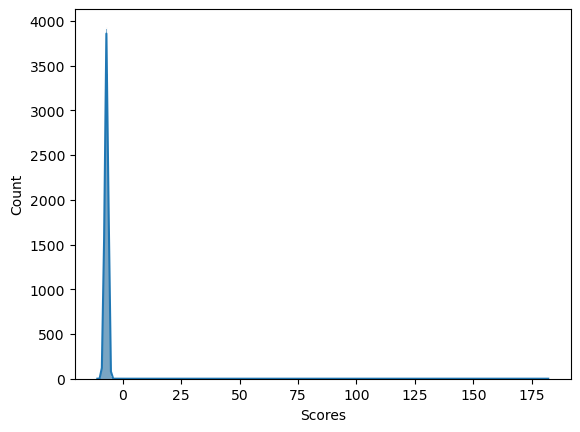

In [16]:
sns.histplot(data=database, x='Scores', kde=True);

In [17]:
(database.Scores > 0).sum()

66

This is real data, and some molecules just don't fit the pocket, leading to positive(!) binding energies. We can remove those examples fro the dataset:

In [18]:
database = database.drop(database[ database.Scores > 0 ].index)

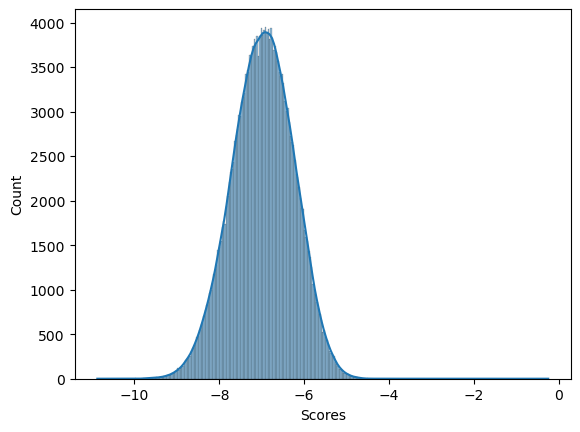

In [19]:
sns.histplot(data=database, x='Scores', kde=True);

Better now.

In [23]:
database.describe()

,Scores
count,221438.000000
mean,-6.975614
std,0.726020
min,-10.875000
25%,-7.465750
50%,-6.962000
75%,-6.470000
max,-0.244000


# Random Selection of 10K molecules
Remember, in principle you don't have the docking scores. So, we first make a random selection of molecules to dock and use the results to create a model.

In [24]:
N_SAMPLE = 10_000 # you can play with this to see if you can get a better model

In [25]:
random_sel = database.sample(N_SAMPLE, random_state=42, ignore_index=True)

Look at the selection. It should follow approximately the same distribution as the full database.

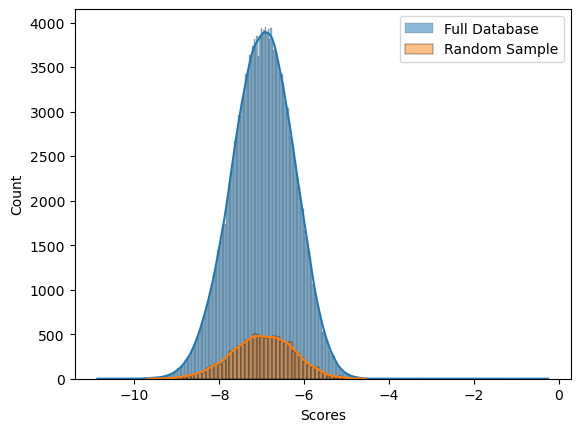

In [26]:
sns.histplot(data=database,   x='Scores', kde=True, label="Full Database");
sns.histplot(data=random_sel, x='Scores', kde=True, label="Random Sample");
plt.legend();

# Models from random sample
Now, let's create a couple of models. You can try other models later!

In [27]:
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

In [28]:
X, y = random_sel.RDKit.values.tolist(), random_sel.Scores.values.tolist()

## Random Forest Classifier

For a classifier, we need to make the data categorical. The threshold is arbitrary, and may change depending on the project. Here, we just set it so 30% of the molecules are considered "active".

In [29]:
# Make categorical data
# This is an arbitrary threshold, and will vary by project
threshold = np.percentile(y,30)
y_cls = [ score < threshold for score in y]

print(f"Threshold score:  {threshold:.2f}")
print(f"Negative samples: {len(y_cls) - np.sum(y_cls):6,} ({(len(y_cls) -  np.sum(y_cls))/len(y_cls):.2%})")
print(f"Positive samples: {np.sum(y_cls):6,} ({(np.sum(y_cls))/len(y_cls):.2%})")
print(f"  Total ------ -> {len(y_cls):6,}")

Threshold score:  -7.35
Negative samples:  7,000 (70.00%)
Positive samples:  3,000 (30.00%)
  Total ------ -> 10,000


We have plenty of molecules, lets save 20% for testing and create the model with 80%.

In [31]:
X_train_cls, X_test_cls, y_train_cls, y_test_cls = train_test_split(X, y_cls, 
                                                                    test_size = 0.20,
                                                                    random_state=42,
                                                                    shuffle=True,
                                                                    stratify=y_cls)

In [32]:
print("Training set:")
print(f"  Negative samples: {len(y_train_cls) - np.sum(y_train_cls):6,} ({(len(y_train_cls) -  np.sum(y_train_cls))/len(y_train_cls):.2%})")
print(f"  Positive samples: {np.sum(y_train_cls):6,} ({(np.sum(y_train_cls))/len(y_train_cls):.2%})")
print(f"  Total ----------> {len(y_train_cls):6,}")
print("\nTesting set:")
print(f"  Negative samples: {len(y_test_cls) - np.sum(y_test_cls):6,} ({(len(y_test_cls) -  np.sum(y_test_cls))/len(y_test_cls):.2%})")
print(f"  Positive samples: {np.sum(y_test_cls):6,} ({(np.sum(y_test_cls))/len(y_test_cls):.2%})")
print(f"  Total ----------> {len(y_test_cls):6,}")

Training set:
  Negative samples:  5,600 (70.00%)
  Positive samples:  2,400 (30.00%)
  Total ---------->  8,000

Testing set:
  Negative samples:  1,400 (70.00%)
  Positive samples:    600 (30.00%)
  Total ---------->  2,000


Now we can train our classifier

In [33]:
clf = RandomForestClassifier(random_state=42, verbose=1)

In [34]:
%%time
clf.fit(X_train_cls,y_train_cls)

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    2.9s


CPU times: user 5.85 s, sys: 4.98 ms, total: 5.86 s
Wall time: 5.97 s


RandomForestClassifier(random_state=42, verbose=1)

In [35]:
y_pred_cls = clf.predict(X_test_cls)

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


In [36]:
print(f"Accuracy:  {metrics.accuracy_score(y_test_cls, y_pred_cls):.2f}")
print(f"F1-Score:  {metrics.f1_score(y_test_cls, y_pred_cls):.2f}")
print(f"Precision: {metrics.precision_score(y_test_cls, y_pred_cls):.2f}")
print(f"Recall:    {metrics.recall_score(y_test_cls, y_pred_cls):.2f}" )
print(f"ROC_AUC:   {metrics.roc_auc_score(y_test_cls, y_pred_cls):.2f}" )

Accuracy:  0.77
F1-Score:  0.48
Precision: 0.72
Recall:    0.35
ROC_AUC:   0.65


In [ ]:
print(f"Confusion Matrix:\n {metrics.confusion_matrix(y_test_cls, y_pred_cls)}")

## Random Forest Regressor
Can we do better with a regression model?

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size = 0.30,
                                                    random_state=42,
                                                    shuffle=True)

In [39]:
print('Training set: ', len(X_train))
print('Testing set:  ', len(X_test))

Training set:  7000
Testing set:   3000


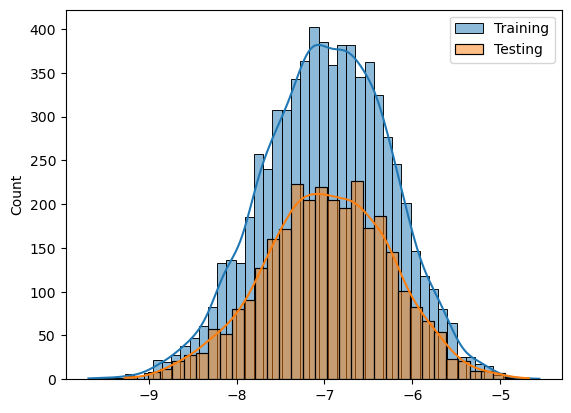

In [40]:
sns.histplot(x=y_train,stat='count', kde=True, label="Training");
sns.histplot(x=y_test ,stat='count', kde=True, label="Testing");
plt.legend();

In [41]:
reg = RandomForestRegressor(random_state=42, n_jobs=4, verbose=1)

In [42]:
%%time
reg.fit(X_train,y_train)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   34.2s


CPU times: user 5min 1s, sys: 69.2 ms, total: 5min 1s
Wall time: 1min 18s


[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:  1.3min finished


RandomForestRegressor(n_jobs=4, random_state=42, verbose=1)

In [43]:
y_pred = reg.predict(X_test)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


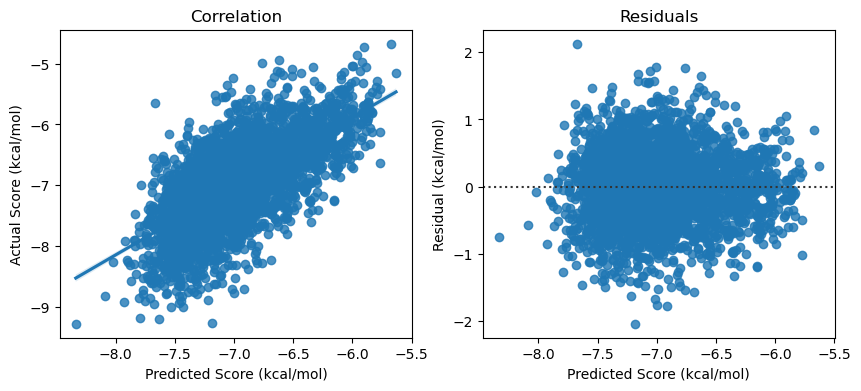

In [44]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,4))
sns.regplot(x=y_pred, y=y_test, ax=ax[0]);
sns.residplot(x=y_pred, y=y_test, ax=ax[1]);
ax[0].title.set_text('Correlation')
ax[1].title.set_text('Residuals')

ax[0].set_xlabel('Predicted Score (kcal/mol)')
ax[1].set_xlabel('Predicted Score (kcal/mol)')

ax[0].set_ylabel('Actual Score (kcal/mol)')
ax[1].set_ylabel('Residual (kcal/mol)');

In [45]:
from scipy.stats import pearsonr
pearson_corr = pearsonr(y_pred,y_test)
print(f"Pearson Correlation Coefficient: {pearson_corr[0]:.2f}")
print(f"                    and P-Value: {pearson_corr[1]}")

Pearson Correlation Coefficient: 0.67
                    and P-Value: 0.0


# Scan the Full DB with the Regression Model
Let's use the regression model obtained to screen the whole library.

In [47]:
%%time
predicted_scores = reg.predict(database.RDKit.values.tolist())

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.4s


CPU times: user 11 s, sys: 157 ms, total: 11.1 s
Wall time: 3.49 s


[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    3.0s finished


With that, we scanned the whole library in less than 4 seconds. Compare to the estimated >25 days it would take to dock all molecules.

Add those results to the database:

In [48]:
database['Predictions'] = predicted_scores

# Select top 10k molecules based on predictions
Finally, we would use the predicted scores to select molecules for the next round of docking. Since we already have the docking energies here, we can just collect the data from the database. But remember: in a real application, you would need to dock the selected molecules.

In [49]:
biased_sel = database.sort_values(by=['Predictions'], ascending=True)[:N_SAMPLE]

Finally, let's compare to the random selection of molecules

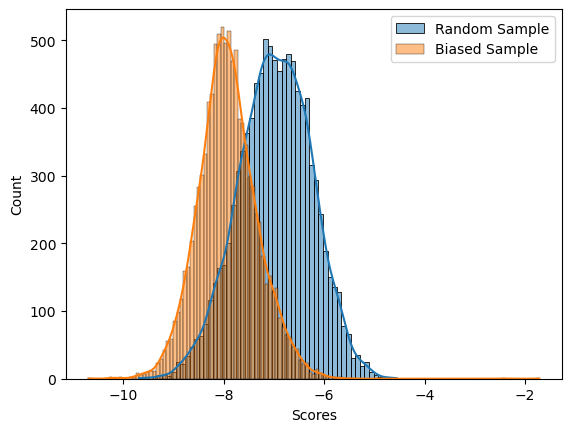

In [50]:
sns.histplot(data=random_sel, x='Scores', kde=True, label="Random Sample");
sns.histplot(data=biased_sel, x='Scores', kde=True, label="Biased Sample");
plt.legend();

Looks like we did get some improvement. Let's look at more detailed statistics, and compare with the full database:

In [51]:
desc_full = database.Scores.describe()
desc_random = random_sel.Scores.describe()
desc_biased = biased_sel.Scores.describe()
desc_stats = desc_random.index

desc_df = pd.DataFrame(columns=desc_stats, data=np.array(list(zip(desc_full.values, desc_random.values, desc_biased.values))).transpose())
desc_df.drop(columns='count', inplace=True)
desc_df.index = ['Full Database','Random Selection','Biased Selection']
desc_df

,mean,std,min,25%,50%,75%,max
Full Database,-6.975614,0.726020,-10.875,-7.46575,-6.962,-6.47000,-0.244
Random Selection,-6.978058,0.722463,-9.684,-7.46500,-6.967,-6.46975,-4.556
Biased Selection,-7.915125,0.590947,-10.691,-8.29125,-7.940,-7.55900,-1.716


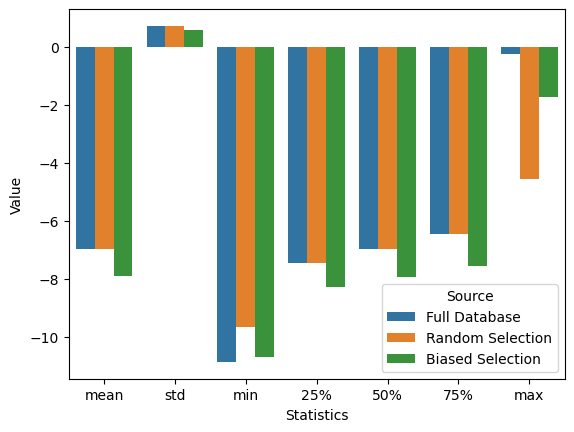

In [52]:
desc_long = pd.melt(desc_df.transpose().reset_index(names='Statistics'), id_vars=['Statistics'], value_vars=['Full Database','Random Selection','Biased Selection'], 
                    var_name='Source', value_name='Value')
sns.barplot(data=desc_long, x='Statistics', y='Value', hue='Source');

Notice that the random selection is very similar to the full database, except in the `min` measure. What does that mean?

<div class="alert alert-success" role="alert">
    <b>That's it for today</b> </br>
    As an exercise, see if you can get a better model by changing the method and/or adjusting hyperparameters!
</div>